In [1]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

You should consider upgrading via the 'C:\Users\abul4\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement torchvision<0.9,>=0.8 (from fastai) (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2)
ERROR: No matching distribution found for torchvision<0.9,>=0.8
You should consider upgrading via the 'C:\Users\abul4\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
! kaggle datasets download nikitarom/planets-dataset

Dataset URL: https://www.kaggle.com/datasets/nikitarom/planets-dataset
License(s): DbCL-1.0




  0%|          | 0.00/1.50G [00:00<?, ?B/s]
  0%|          | 1.00M/1.50G [00:01<39:09, 685kB/s]
  0%|          | 2.00M/1.50G [00:01<19:47, 1.35MB/s]
  0%|          | 3.00M/1.50G [00:01<12:04, 2.22MB/s]
  0%|          | 5.00M/1.50G [00:02<06:27, 4.14MB/s]
  0%|          | 7.00M/1.50G [00:02<04:11, 6.36MB/s]
  1%|          | 9.00M/1.50G [00:02<03:14, 8.24MB/s]
  1%|          | 11.0M/1.50G [00:02<02:34, 10.3MB/s]
  1%|          | 13.0M/1.50G [00:02<02:17, 11.6MB/s]
  1%|          | 15.0M/1.50G [00:02<02:02, 13.0MB/s]
  1%|          | 17.0M/1.50G [00:02<01:51, 14.3MB/s]
  1%|          | 19.0M/1.50G [00:02<01:45, 15.1MB/s]
  1%|▏         | 21.0M/1.50G [00:03<01:41, 15.6MB/s]
  1%|▏         | 23.0M/1.50G [00:03<01:41, 15.6MB/s]
  2%|▏         | 25.0M/1.50G [00:03<01:36, 16.3MB/s]
  2%|▏         | 27.0M/1.50G [00:03<01:37, 16.2MB/s]
  2%|▏         | 29.0M/1.50G [00:03<01:32, 17.0MB/s]
  2%|▏         | 31.0M/1.50G [00:03<01:36, 16.3MB/s]
  2%|▏         | 33.0M/1.50G [00:03<01:31, 17.2MB/s]
  

In [6]:
!unzip planets-dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
import tqdm as notebook_tqdm
from fastai.vision.all import *
path = Path('./planet/planet')

In [11]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [12]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


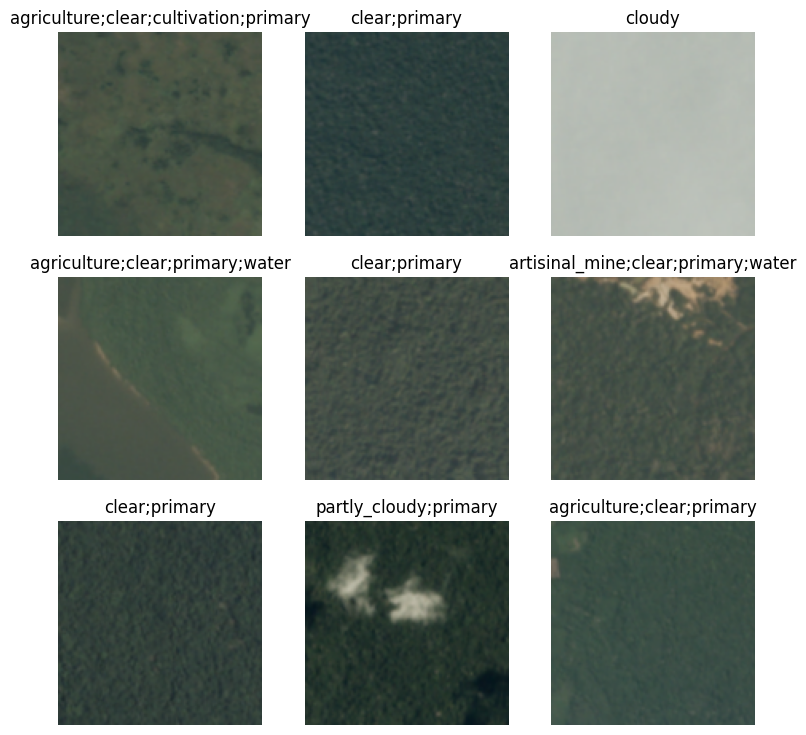

In [14]:
dls = get_data(128,256)
dls.show_batch()

In [15]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=2, average='samples', thresh=0.2)]
cbs = [MixUp]

c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\abul4/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 41.7MB/s]


SuggestedLRs(valley=0.0006918309954926372)

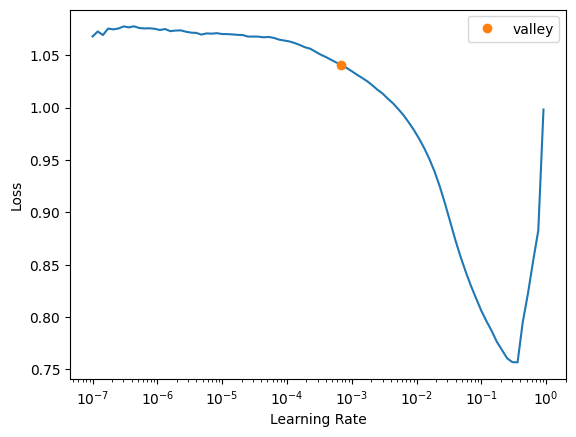

In [16]:
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

In [17]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.377429,0.144340,0.927479,0.870373,09:24
1,0.198808,0.129395,0.929557,0.883447,04:01
2,0.173652,0.120112,0.940384,0.892632,03:49
3,0.163092,0.112235,0.941809,0.900203,06:07


c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating k

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.147300,0.097346,0.950950,0.918679,03:57
1,0.144654,0.095630,0.950957,0.918543,03:59
2,0.139566,0.093482,0.953094,0.919712,03:57
3,0.135930,0.090740,0.953261,0.922820,03:59
4,0.131328,0.085784,0.956647,0.926997,03:58
5,0.127500,0.085025,0.957555,0.927755,04:08


c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating k

In [18]:
learn.save('calhack_2024_v1')

Path('models/calhack_2024_v1.pth')

c:\Users\abul4\AppData\Local\Programs\Python\Python310\lib\site-packages\fastai\data\transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


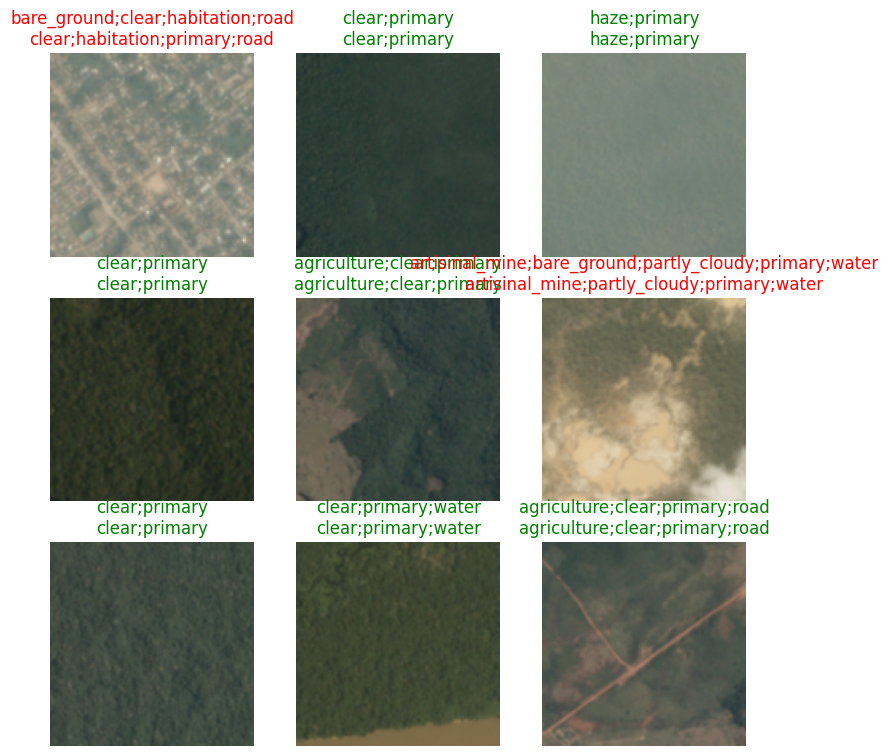

In [19]:
learn.show_results()

In [20]:
learn.export() # if we want .pkl file for proper end to end deployment (file will be saved as export.pkl)

In [ ]:
#inference = learn.load('resnet50-128')

In [43]:
from pathlib import Path
import pandas as pd

additional_test_path = Path(r'C:\Users\abul4\OneDrive\Desktop\QWERTY\test-jpg-additional')
test_path = Path(r'planet/planet/test-jpg')
submission_df = pd.read_csv(r'C:\Users\abul4\OneDrive\Desktop\QWERTY\planet\planet\sample_submission.csv')

# Constructing file paths based on the file names in the submission
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path / x if x.startswith('test') else additional_test_path / x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl=tst_dl)
    else:
        predictions = learn.get_preds(dl=tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

prediction('submission_tta.csv', tta=True)


,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear partly_cloudy primary
4,test_4,partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,agriculture clear primary water
61188,file_9997,clear primary road water
61189,file_9998,cloudy


In [38]:
prediction('submission_tta.csv', tta=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\abul4\\OneDrive\\Desktop\\QWERTY\\test-jpg-additional\\test_0.jpg'